In [1]:
import torch 
from os.path import join 
from PIL import Image 
from torch import nn 
from os import makedirs
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib import pyplot as plt 
import shutil
from typing import List
from torchvision.transforms import v2 
import pandas as pd 
import os 
import albumentations as A
import cv2 
import numpy as np

In [2]:
df = pd.read_csv('/home/shivac/qml-data/csv_files/org_val_9.csv') 
df.head()

,Unnamed: 0,patient_id,idx,aster_img_path,aster_mask_path,img_path,mask_path
0,70304,MEDVID0080_M_20211124_121609_0001_IMAGES,0,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,MEDVID0080_M_20211124_121609_0001_IMAGES/0/img...,MEDVID0080_M_20211124_121609_0001_IMAGES/0/mas...
1,70305,MEDVID0080_M_20211124_121609_0001_IMAGES,1,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,MEDVID0080_M_20211124_121609_0001_IMAGES/1/img...,MEDVID0080_M_20211124_121609_0001_IMAGES/1/mas...
2,70306,MEDVID0080_M_20211124_121609_0001_IMAGES,10,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,MEDVID0080_M_20211124_121609_0001_IMAGES/10/im...,MEDVID0080_M_20211124_121609_0001_IMAGES/10/ma...
3,70307,MEDVID0080_M_20211124_121609_0001_IMAGES,100,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,MEDVID0080_M_20211124_121609_0001_IMAGES/100/i...,MEDVID0080_M_20211124_121609_0001_IMAGES/100/m...
4,70308,MEDVID0080_M_20211124_121609_0001_IMAGES,101,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,./MEDVID0080_M_20211124_121609/MEDVID0080_M_20...,MEDVID0080_M_20211124_121609_0001_IMAGES/101/i...,MEDVID0080_M_20211124_121609_0001_IMAGES/101/m...


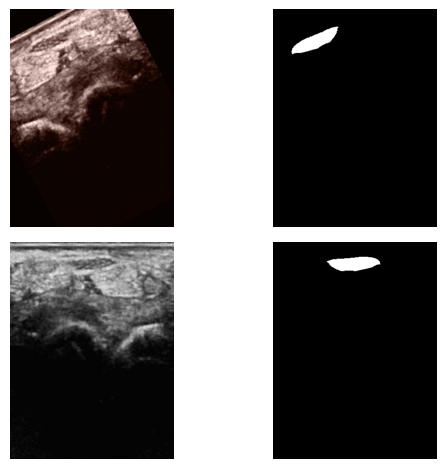

In [3]:
transform = v2.Compose([v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True),])

transform = A.Compose(
    [
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
    ]
)

idx = 0

img = Image.open(os.path.join('/home/shivac/qml-data/', df.img_path[idx])) 
mask = Image.open(os.path.join('/home/shivac/qml-data/', df.mask_path[idx])) 
img = np.array(img) 
mask = np.array(mask)
data = transform(image=img, mask=mask)
img = data['image']
mask = data['mask']
plt.subplot(2, 2, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(2, 2, 2)
plt.axis('off')
plt.imshow(mask, cmap='gray')

transform = A.Compose(
    [
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
    ]
)
img = Image.open(os.path.join('/home/shivac/qml-data/', df.img_path[idx]))#.convert('L') 
mask = Image.open(os.path.join('/home/shivac/qml-data/', df.mask_path[idx])) 
img = np.array(img) 
mask = np.array(mask)
data = transform(image=img, mask=mask)
img = data['image']
mask = data['mask']

plt.subplot(2, 2, 3)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(2, 2, 4)
plt.axis('off')
plt.imshow(mask, cmap='gray')
plt.tight_layout()

plt.show()

img.shape, mask.shape = (torch.Size([3, 456, 342]), torch.Size([1, 456, 342]))


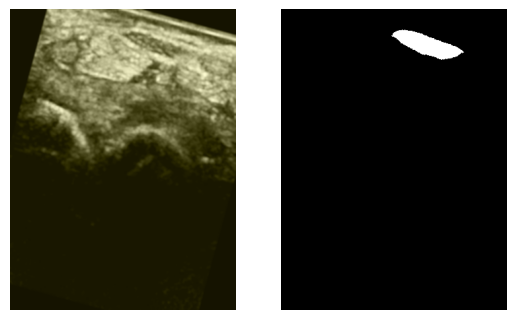

In [5]:
from dataset import Pic_to_Pic_dataset 
dataset = Pic_to_Pic_dataset('/home/shivac/qml-data/csv_files/org_val_9.csv', 'train') 
img, mask = dataset[0]
print(f'{img.shape, mask.shape = }')
img = img.permute(1, 2, 0)
mask = mask.permute(1, 2, 0)

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(mask, cmap='gray')
plt.show()

In [6]:
img.dtype

torch.float32

In [ ]:
def forward_hook(module: nn.Module, input: torch.Tensor, output: torch.Tensor) -> None: 
    save_path = join('visual', module.model_name) 
    makedirs(save_path, exist_ok=True)
    save_path = join(save_path, module.name + '.pt')
    torch.save(output, save_path)



In [ ]:
!rm -r visual

rm: cannot remove 'visual': No such file or directory


In [ ]:
def save_feature_maps(img_path: str, model_name: str, ckpt_path: str) -> None:  
    if model_name == 'unet': 
        from models import UNET 
        model = UNET().cuda() 
        model.load_state_dict(torch.load(ckpt_path)['model_state'])
        model.down4.register_forward_hook(forward_hook)
        model.down3.register_forward_hook(forward_hook)
    elif model_name == 'q_unet': 
        from models import Q_UNET 
        model = Q_UNET().cuda() 
        model.load_state_dict(torch.load(ckpt_path)['model_state'])
        model.down4.register_forward_hook(forward_hook)
        model.down3.register_forward_hook(forward_hook)
    else:
        print(f'{model_name} is unavailable')
        return
    model.assign_names()
    img = Image.open(img_path).convert('L') 
    img = ToTensor()(img).cuda().unsqueeze(0)
    preds = model(img) 
    plt.imshow(preds[0][0].detach().cpu(), cmap='gray')
    plt.axis('off')
    plt.show()
    pred_path = join('visual', model_name, 'ouput.png') 
    mask_path = img_path.split('/') 
    mask_path[-2] = 'masks' 
    mask_path[-1] = mask_path[-1][:-3]
    mask_path[-1] += 'tif'
    mask_path = '/'.join(mask_path)
    shutil.copy(mask_path, join('visual', model_name, 'mask.png'))
    shutil.copy(img_path, join('visual', model_name, 'input.png')) 
    ToPILImage()(preds[0]).save(pred_path)
    

    

In [ ]:
def visualize(img_path: str, model_names: List[str], ckpt_paths: List[str]) -> None: 
    save_feature_maps(img_path, model_names[0], ckpt_paths[0])
    save_feature_maps(img_path, model_names[1], ckpt_paths[1]) 
    
    

Assigning names to layers


/home/shivac/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


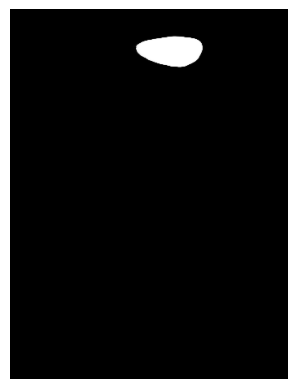

Assigning names to layers


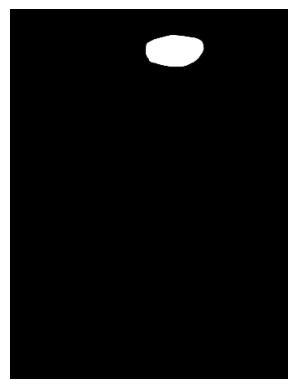

In [ ]:
visualize('./res/images/50.jpg', ['unet', 'q_unet'], ['ckpts/unet-0.1/2/best_unet.pth', 'ckpts/q-unet-0.1/3/best_q_unet.pth'])

In [ ]:
------------

SyntaxError: invalid syntax (1366586092.py, line 1)

In [ ]:
import torch 
from dataset import Pic_to_Pic_dataset
from models import UNET, U2NET
from torch.utils.data import DataLoader
from loss import SSIM_DICE_BCE, DiceScore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from PIL import Image 
from torchvision.transforms import ToTensor, ToPILImage
import os 
from tqdm import tqdm 
import cv2
from typing import List

torch.set_grad_enabled(False)

In [ ]:
def forward_hook(module, input, output): 
    print(output.shape) 

In [ ]:
img = 

In [ ]:
os.system('rm -r plots')

In [ ]:

def get_depth_gen(length: int):
    lst = list()
    for i in range(length):
        lst.extend([i]*10)
    for depth in lst:
        yield depth

In [ ]:
def forward_hook(module, input, output): 
    batch_size = output.shape[0]

        # print(depth)
        for idx, img in enumerate(op): 
            path = os.path.join('plots', patient_id, depth, module.name)
            os.makedirs(path, exist_ok=True)
            idx = str(len(os.listdir(path)))
            img = (img-img.min())/(img.max()-img.min())
            # print(path)
            ToPILImage()(img).save(path+ '/' + str(idx) + '.png')


In [ ]:
model = UNET().to('cuda:1')
model.assign_names()
ckpt = torch.load('./ckpts/quantum_noise/56/best_unet.pth') 
model.load_state_dict(ckpt['model_state'])
dice_score = DiceScore()
# print(model)


model.ch.register_forward_hook(forward_hook)
model.down1.register_forward_hook(forward_hook)
model.down2.register_forward_hook(forward_hook)
model.down3.register_forward_hook(forward_hook)
model.down4.register_forward_hook(forward_hook)
model.up1.register_forward_hook(forward_hook)
model.up2.register_forward_hook(forward_hook)
model.up3.register_forward_hook(forward_hook)
model.up4.register_forward_hook(forward_hook)
model.out.register_forward_hook(forward_hook)

In [ ]:
whole_df = pd.read_csv('/home/shivac/qml-data/csv_files/val_10_org.csv') 
patient_ids = whole_df['patient_id'].unique()
patient_id = np.random.choice(patient_ids)
global batch_num 
batch_num = 0
img_paths = whole_df[whole_df['patient_id'] == patient_id]['img_path'].values
img_paths = [os.path.join('/home/shivac/qml-data/', img_path) for img_path in img_paths]
batch_img = list() 
for img_path in img_paths: 
    img = Image.open(img_path).convert('L') 
    img = ToTensor()(img)
    batch_img.append(img)
batch_img = torch.stack(batch_img)
batch_size = 10
batch_img = batch_img.split(batch_size)
depth_gen = get_depth_gen(len(img_paths)//batch_size+1)
print(f'{len(batch_img)}')
with torch.no_grad():
    for img in tqdm(batch_img): 
        logits = model(img.to('cuda:1'))

In [ ]:
def imgs_to_vid(path): 
    imgs = os.listdir(path)
    imgs = [os.path.join(path, img) for img in imgs if img.endswith('.png')]
    imgs = sorted(imgs, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    if len(imgs) == 0: 
        print('No images found in {}'.format(path))
        return
    img = cv2.imread(imgs[0])
    video = cv2.VideoWriter('{}/vid.mp4'.format(path), cv2.VideoWriter_fourcc(*'mp4v'), 10, (img.shape[1], img.shape[0]))
    
    for img_path in tqdm(imgs): 
        if not img_path.endswith('.png'): 
            continue
        img = cv2.imread(img_path)
        video.write(img)       
    video.release()
    os.system(f'rm {path}/*.png')



In [ ]:
plots_path = 'plots_imgs/'
patient_dirs = os.listdir(plots_path) 
for patient_dir in patient_dirs:
    patient_dir_path = os.path.join(plots_path, patient_dir)
    for depth in tqdm(os.listdir(patient_dir_path)): 
        depth_path = os.path.join(patient_dir_path, depth)
        for module in os.listdir(depth_path): 
            module_path = os.path.join(depth_path, module)
            imgs_to_vid(module_path)
           




  0%|          | 0/300 [00:00<?, ?it/s]

No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/down2
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/out
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/down3
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/up3
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/up4
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/up2
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/down1
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/down4
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/ch
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/158/up1
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/81/down2
No images found in plots_imgs/MEDVID0082_M_20211125_175015_0001_IMAGES/81/out
No images found in plots_imgs/MEDVID0082_M_20

100%|██████████| 300/300 [03:55<00:00,  1.28it/s]


In [ ]:
whole_df = pd.read_csv('/home/shivac/qml-data/csv_files/val_10_org.csv') 
patient_ids = np.unique(whole_df.patient_id)
model.eval()
for patient_id in patient_ids:
    os.makedirs('plots/{}'.format(patient_id), exist_ok=True)
    df = whole_df[whole_df.patient_id == patient_id].sort_values('idx')
    df.reset_index(inplace=True)
    path_gen = path_gen_fn(['plots/{}/{}/'.format(patient_id, i) for i in range(len(df))])
    for i in tqdm(range(len(df))): 
        os.makedirs('plots/{}/{}'.format(patient_id, i), exist_ok=True)
        img_path = '/home/shivac/qml-data/' + df.loc[i].img_path
        mask_path = '/home/shivac/qml-data/' + df.loc[i].mask_path
        img = Image.open(img_path).convert('L')                         
        mask = Image.open(mask_path) 
        mask = ToTensor()(mask).unsqueeze(0)
        img = ToTensor()(img).unsqueeze(0)
        logits = model(img.cuda())
        dice = round(dice_score(mask.cuda(), logits).item(), 2)

        plt.figure(figsize=(10, 6), facecolor='gray')
        plt.axis('off')
        plt.title('Depth: ' + str(i) + ' dice_score: ' + str(dice))
        plt.subplot(1,3,1)
        plt.title('img')
        plt.axis('off')
        plt.imshow(img[0].permute(1,2,0), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('mask')
        plt.axis('off')
        plt.imshow(mask[0].permute(1,2,0), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('logits')
        plt.axis('off')
        plt.imshow(logits[0].detach().cpu().permute(1,2,0), cmap='gray')
        plt.savefig('plots/{}/{}/res.png'.format(patient_id, i))
        plt.clf() 
        plt.close()
        for path in os.listidir('plots/{}/{}'.format(patient_id, i)):
            imgs_to_vid(os.path.join(path, 'ch/'))
    break
        
        


NameError: name 'model' is not defined

In [ ]:
patient_id